In [2]:
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from scipy.interpolate import BSpline
from cmdstanpy import CmdStanModel
import arviz as az
import pandas as pd
from glob import glob
from sklearn import preprocessing

from DA_tools.DA_tools import ribbon_plot
from DA_tools.DA_colors import *

plt.style.context("seaborn-white")
mpl.rcParams["figure.dpi"] = 200


In [3]:
signals_healthy_x = np.zeros((10,), dtype = object)
signals_healthy_y = np.zeros((10,), dtype = object)
for i in range(10):
    a = pd.read_csv('processed_data1/signals_healthy_{}.csv'.format(i)) 
    signals_healthy_y[i] = a.to_numpy()[0]
    signals_healthy_x[i] = a.to_numpy()[1]

signals_damaged_1_y = np.zeros((10,), dtype = object)
signals_damaged_1_x = np.zeros((10,), dtype = object)
for i in range(10):
    a = pd.read_csv('processed_data1/signals_damaged_1_{}.csv'.format(i)) 
    signals_damaged_1_y[i] = a.to_numpy()[0]
    signals_damaged_1_x[i] = a.to_numpy()[1]

signals_damaged_2_y = np.zeros((10,), dtype = object)
signals_damaged_2_x = np.zeros((10,), dtype = object)
for i in range(10):
    a = pd.read_csv('processed_data1/signals_damaged_2_{}.csv'.format(i)) 
    signals_damaged_2_y[i] = a.to_numpy()[0]
    signals_damaged_2_x[i] = a.to_numpy()[1]

signals_damaged_ring_y = np.zeros((13,), dtype = object)
signals_damaged_ring_x = np.zeros((13,), dtype = object)
for i in range(13):
    a = pd.read_csv('processed_data1/signals_damaged_ring_{}.csv'.format(i)) 
    signals_damaged_ring_y[i] = a.to_numpy()[0]
    signals_damaged_ring_x[i] = a.to_numpy()[1]

In [4]:
signals_damaged_y = np.array([],dtype=object)
signals_damaged_x = np.array([],dtype=object)

signals_damaged_y = np.append(signals_damaged_y,signals_damaged_1_y)
signals_damaged_y = np.append(signals_damaged_y,signals_damaged_2_y)
signals_damaged_y = np.append(signals_damaged_y,signals_damaged_ring_y)
signals_damaged_x = np.append(signals_damaged_x,signals_damaged_1_x)
signals_damaged_x = np.append(signals_damaged_x,signals_damaged_2_x)
signals_damaged_x = np.append(signals_damaged_x,signals_damaged_ring_x)

In [5]:
def create_spline_matrix(time, spl_order=3, num_knots=10):
    """
    N - Number of time series,
    time - array/series of time values

    """
    knot_list = np.quantile(time, np.linspace(0, 1, num_knots))
    knots = np.pad(knot_list, (spl_order, spl_order), mode="edge")
    B = BSpline(knots, np.identity(num_knots + 2), k=spl_order)(time[0:len(time)])
    # Design matrix
    return B

min_max_scaler = preprocessing.MinMaxScaler()    

In [6]:
IL1 = 4
IL2 = 4
IL = IL1 + IL2
I = 2

np.random.seed(21112022)

sampling_order_1 = np.random.permutation([*range(10)])
sampling_order_2 = np.random.permutation([*range(33)])
sampling_order_3 = np.random.permutation([*range(43-IL)])

In [7]:

y_labeled = np.concatenate(
    [signals_healthy_y[sampling_order_1[:IL1]],
        signals_damaged_y[sampling_order_2[:IL2]]]
)


labels = np.concatenate([np.ones(IL1), 2*np.ones(IL2)]).astype(int)


y_rest = np.concatenate(
    [signals_healthy_y[sampling_order_1[IL1:]],
        signals_damaged_y[sampling_order_2[IL2:]]]
)

y_rest_time = np.concatenate(
    [signals_healthy_x[sampling_order_1[IL1:]],
        signals_damaged_x[sampling_order_2[IL2:]]]
)


y_rest_labels = np.concatenate([np.ones(10-IL1), 2*np.ones(33-IL2)])

y = y_rest[sampling_order_3[:I]]
lambda0 = np.array([IL1/IL, IL2/IL])

y_test = y_rest[sampling_order_3[I:]]


IT = y_test.shape[0]
temp = np.array([])
N_labeled = np.array([])
for i in range(len(y_labeled)):
    N_labeled = np.append(N_labeled,len(y_labeled[i]))

In [8]:
N_labeled = np.array([])
temp = np.array([])
for i in range(len(y_labeled)):
    N_labeled = np.append(N_labeled,len(y_labeled[i]))
    temp = np.append(temp,y_labeled[i])
y_labeled = temp


N = np.array([])
temp = np.array([])
for i in range(len(y)):
    N = np.append(N,len(y[i]))
    temp = np.append(temp,y[i])
y = temp

N_test = np.array([])
temp = np.array([])
for i in range(len(y_test)):
    N_test = np.append(N_test,len(y_test[i]))
    temp = np.append(temp,y_test[i])
y_test = temp  

In [9]:
N_labeled = N_labeled.astype(int)
N = N.astype(int)
N_test = N_test.astype(int)


In [10]:
spl_order = 3
num_knots = 30
B0_labeled = np.array([])
B0_test = np.array([])
B0 = np.array([])
B0_rest = np.array([])
B0_rest_2 = np.array([])


for i in sampling_order_1[:IL1]:
    time = signals_healthy_x[i]
    knot_list = np.quantile(time, np.linspace(0, 1, num_knots))
    B0_healthy = create_spline_matrix(time, spl_order, num_knots)
    B0_healthy = B0_healthy.reshape(len(time)*(num_knots+2))
    B0_labeled = np.append(B0_labeled,B0_healthy)

for i in sampling_order_2[:IL2]:
    time = signals_damaged_x[i]
    knot_list = np.quantile(time, np.linspace(0, 1, num_knots))
    B0_damaged_1 = create_spline_matrix(time, spl_order, num_knots)
    B0_damaged_1 = B0_damaged_1.reshape(len(time)*(num_knots+2))
    B0_labeled = np.append(B0_labeled,B0_damaged_1)

for i in sampling_order_3[:I]:
    time = y_rest_time[i]
    knot_list = np.quantile(time, np.linspace(0, 1, num_knots))
    B0_rest = create_spline_matrix(time, spl_order, num_knots)
    B0_rest = B0_rest.reshape(len(time)*(num_knots+2))
    B0 = np.append(B0,B0_rest)

for i in sampling_order_3[I:]:
    time = y_rest_time[i]
    knot_list = np.quantile(time, np.linspace(0, 1, num_knots))
    B0_rest_2 = create_spline_matrix(time, spl_order, num_knots)
    B0_rest_2 = B0_rest_2.reshape(len(time)*(num_knots+2))
    B0_test = np.append(B0_test,B0_rest_2)


In [11]:
total_len = np.sum(N).astype(int)
total_len_labeled = np.sum(N_labeled).astype(int)
total_len_test = np.sum(N_test).astype(int)
K = num_knots+2
M = 2

In [12]:
mix1 = CmdStanModel(stan_file="spline_mix_2.stan")


INFO:cmdstanpy:found newer exe file, not recompiling


In [13]:
data_out = {
    "I": I,
    "IL": IL,
    "N": N,
    "N_labeled": N_labeled,
    "total_len": total_len,
    "total_len_labeled": total_len_labeled,
    "K": K,
    "M": M,
    "x": B0,
    "y": y,
    "labels": labels, 
    "x_labeled": B0_labeled,
    "y_labeled": y_labeled,
    "lambda0": lambda0,
    "IT": IT,
    "N_test":N_test,
    "x_test": B0_test,
    "y_test": y_test,
    "total_len_test": total_len_test
}
mx2_result = mix1.sample(data=data_out, seed=21112022,max_treedepth=20)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [14]:
probs_from_arviz = az.summary(
    mx2_result, "log_probabilities", kind='stats', round_to=5)
probs_from_arviz_p = az.summary(
    mx2_result, "probabilities", kind='stats', round_to=5)

In [15]:
indices_cat1 = y_rest_labels[sampling_order_3[I:]] == 1
indices_cat2 = y_rest_labels[sampling_order_3[I:]] == 2

cat1 = probs_from_arviz.iloc[:IT, :].iloc[indices_cat1, :]
cat2 = probs_from_arviz.iloc[IT:2*IT, :].iloc[indices_cat2, :]

cat1p = probs_from_arviz_p.iloc[:IT, :].iloc[indices_cat1, :]
cat2p = probs_from_arviz_p.iloc[IT:2*IT, :].iloc[indices_cat2, :]


a = sum((cat1["mean"].values) < np.log(0.5))
b = sum((cat2["mean"].values) < np.log(0.5))
print(sum((cat1["mean"].values) < np.log(0.5)))
print(sum((cat2["mean"].values) < np.log(0.5)))
hit_rate = 1 - (a+b)/(43-I-IL)
print('hit rate = ',hit_rate)


3
15
hit rate =  0.4545454545454546


In [16]:
lambda_summary = az.summary(mx2_result, var_names=[
    'lambda'], filter_vars='like').drop(['mcse_sd', 'hdi_3%', 'hdi_97%'], axis=1)
lambda_summary.index = ['$\lambda_1$', '$\lambda_2$']
lambda_summary.columns = [
    'mean', 'st. dev.',	'$\widehat{\mathrm{MCSE}}$',	'ESS (bulk)', 'ESS (tail)',	'$\widehat{R}$']
lambda_summary

tex_file = open(
    "tables_2cat/table_lambda_summary.tex", "w")
n = tex_file.write(lambda_summary.to_latex(escape=False))
tex_file.close()

C:\Users\kjarz\AppData\Local\Temp/ipykernel_27448/2851200885.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  n = tex_file.write(lambda_summary.to_latex(escape=False))


In [17]:
sigma_summary = az.summary(mx2_result, var_names=[
    'sigma'], filter_vars='like').drop(['mcse_sd', 'hdi_3%', 'hdi_97%'], axis=1)
sigma_summary.index = ['$\sigma_1$', '$\sigma_2$']
sigma_summary.columns = [
    'mean', 'st. dev.',	'$\widehat{\mathrm{MCSE}}$',	'ESS (bulk)', 'ESS (tail)',	'$\widehat{R}$']
sigma_summary

tex_file = open(
    "tables_2cat/table_sigma_summary.tex", "w")
n = tex_file.write(sigma_summary.to_latex(escape=False))
tex_file.close()

C:\Users\kjarz\AppData\Local\Temp/ipykernel_27448/4091666091.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  n = tex_file.write(sigma_summary.to_latex(escape=False))


In [18]:
beta_1 = az.summary(mx2_result, var_names=['beta']).filter(
    like=', 0]', axis=0).loc[:, 'mean':'hdi_97%']

beta_2 = az.summary(mx2_result, var_names=['beta']).filter(
    like=', 1]', axis=0).loc[:, 'mean':'hdi_97%']

betas = [beta_1,beta_2]

In [19]:
beta_1.index = ['$\\beta_{1,'+str(k)+'}$' for k in range(num_knots+2)]
beta_1.columns = ['mean', 'st. dev.', '4\% HDI', '97\% HDI']
tex_file = open(
    "tables_2cat/table_beta_1_summary.tex", "w")
n = tex_file.write(beta_1.to_latex(escape=False))
tex_file.close()

C:\Users\kjarz\AppData\Local\Temp/ipykernel_27448/2094869802.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  n = tex_file.write(beta_1.to_latex(escape=False))


In [20]:
beta_2.index = ['$\\beta_{1,'+str(k)+'}$' for k in range(num_knots+2)]
beta_2.columns = ['mean', 'st. dev.', '4\% HDI', '97\% HDI']
tex_file = open(
    "tables_2cat/table_beta_2_summary.tex", "w")
n = tex_file.write(beta_2.to_latex(escape=False))
tex_file.close()


C:\Users\kjarz\AppData\Local\Temp/ipykernel_27448/2962639957.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  n = tex_file.write(beta_2.to_latex(escape=False))


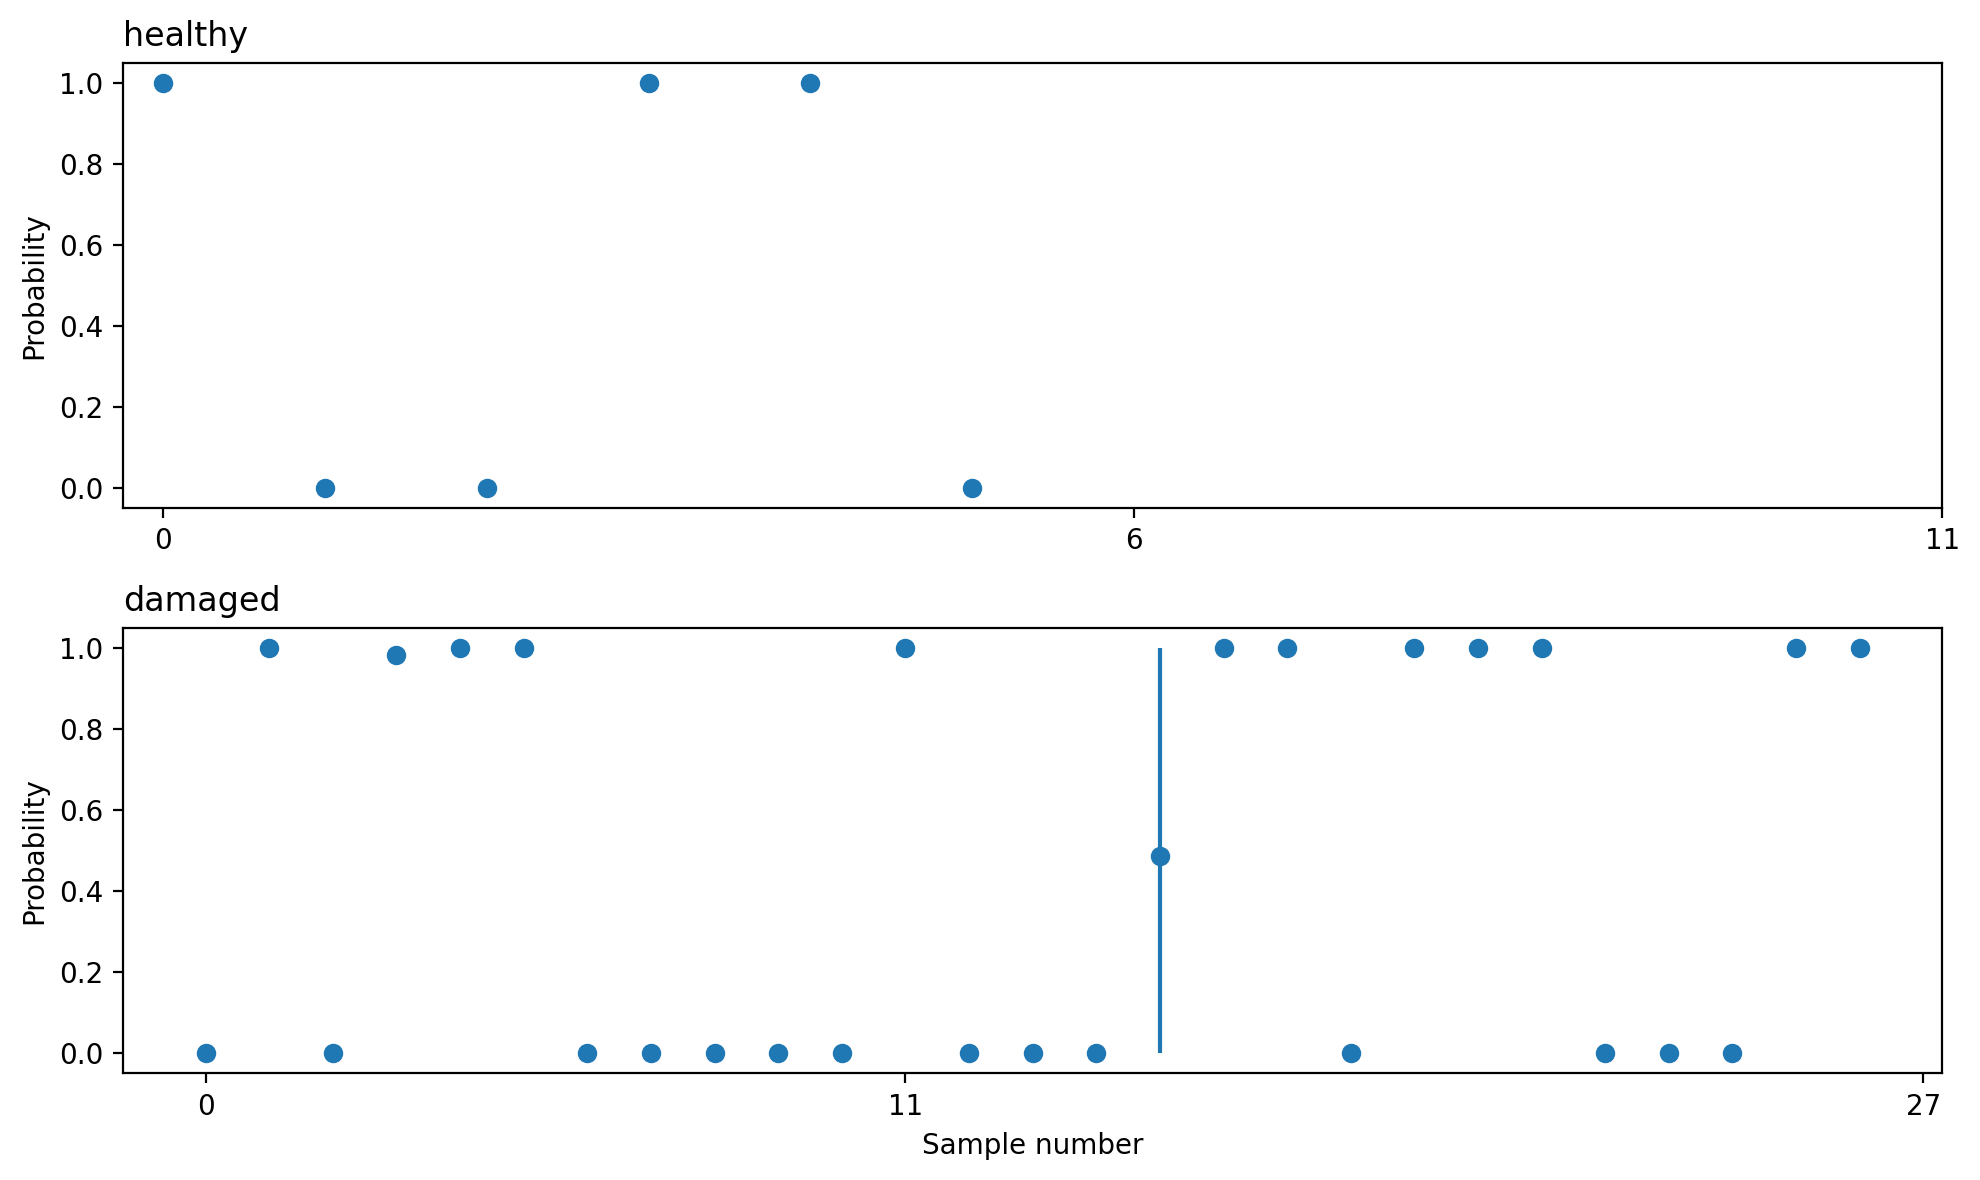

In [24]:
fig, ax = plt.subplots(2,1,figsize=(10,6),tight_layout=True)

x = [*range(len(cat1p))]
ax[0].scatter(x, (cat1p["mean"].values))
ax[0].errorbar(x, cat1p["mean"].values, [cat1p["mean"].values-cat1p["hdi_3%"].values,
             cat1p["hdi_97%"].values-cat1p["mean"].values], linestyle='none')

x = [*range(len(cat2p))]
ax[1].scatter(x, (cat2p["mean"].values))
ax[1].errorbar(x, cat2p["mean"].values, [cat2p["mean"].values-cat2p["hdi_3%"].values,
             cat2p["hdi_97%"].values-cat2p["mean"].values], linestyle='none')

ax[0].set_title('healthy', loc='left')
ax[0].set_ylabel('Probability')
ax[1].set_title('damaged', loc='left')
ax[1].set_ylabel('Probability')
ax[1].set_xlabel('Sample number')
ax[0].set_xticks([0,11,len(cat1p)])
ax[1].set_xticks([0,11,len(cat2p)])


fig.savefig('figures_2cat/class_result_2cat.png')
fig.savefig('figures_2cat/class_result_2cat.pdf', bbox_inches="tight")



In [22]:
# print(mx2_result.diagnose())